In [1]:
dataset = 'cassins'
algorithm = 'scvis'
n_components = 64
dims = (32,32,1)

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [4]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

Using TensorFlow backend.


### load packages

In [5]:
from tfumap.umap import tfUMAP

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [7]:
from tensorflow.keras.datasets import mnist

In [8]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')



top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]
syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])


syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)


Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

  0%|          | 0/26984 [00:00<?, ?it/s]

### Create model and train

In [9]:
from scvis.run import train, map

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
from scvis.model import SCVIS

In [11]:
x = X_train_flat

In [12]:
hyperparameter =  {
  'optimization': {
    'method': 'Adam',
    'learning_rate': 0.01
  },

  'batch_size': 512,
  'max_epoch': 100,
  'regularizer_l2': 0.001,

  'perplexity': 10,

  'seed': 1
}

architecture = {
  'latent_dimension': n_components,

  'inference': {
    'layer_size': [128, 64, 32],
  },

  'model': {
    'layer_size': [32, 32, 32, 64, 128],
  },

  'activation': "ELU"
}

In [13]:
architecture.update({'input_dimension': x.shape[1]})

In [14]:
model = SCVIS(architecture, hyperparameter)



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:21:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [15]:
y = None

In [16]:
from scvis import data

In [17]:
train_data = data.DataSet(x, y)

In [18]:
es = model.train(data=train_data,
                      batch_size=hyperparameter['batch_size'],
                      verbose=True,
                      verbose_interval=50,
                      show_plot=False,
                      plot_dir=None,
                      max_iter=1000,
                      pretrained_model=None)


Batch 0
elbo: -9793.7939453125
scaled_tsne_cost: nan

Batch 50
elbo: -175150.296875
scaled_tsne_cost: nan

Batch 100
elbo: -329395.625
scaled_tsne_cost: nan

Batch 150
elbo: -487155.40625
scaled_tsne_cost: nan

Batch 200
elbo: -651524.25
scaled_tsne_cost: nan

Batch 250
elbo: -819982.9375
scaled_tsne_cost: nan

Batch 300
elbo: -987727.0
scaled_tsne_cost: nan

Batch 350
elbo: -1152136.25
scaled_tsne_cost: nan

Batch 400
elbo: -1277308.75
scaled_tsne_cost: nan

Batch 450
elbo: -1416156.75
scaled_tsne_cost: nan

Batch 500
elbo: -1559508.0
scaled_tsne_cost: nan

Batch 550
elbo: -1738492.75
scaled_tsne_cost: nan

Batch 600
elbo: -1912723.0
scaled_tsne_cost: nan

Batch 650
elbo: -2034597.5
scaled_tsne_cost: nan

Batch 700
elbo: -2225920.0
scaled_tsne_cost: nan

Batch 750
elbo: -2454113.0
scaled_tsne_cost: nan

Batch 800
elbo: -2552034.5
scaled_tsne_cost: nan

Batch 850
elbo: -2745423.75
scaled_tsne_cost: nan

Batch 900
elbo: -2852761.75
scaled_tsne_cost: nan

Batch 950
elbo: -3009675.75
sca

In [19]:
z, _ = model.encode(x)

### Plot model output

In [20]:
%matplotlib inline

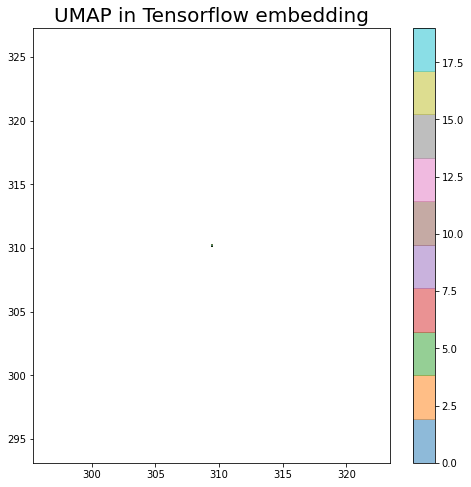

In [21]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [22]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [23]:
output_dir = MODEL_DIR/'projections'/ dataset / str(n_components) / algorithm
ensure_dir(output_dir)

In [24]:
model.save_sess((output_dir / algorithm).as_posix())

In [25]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [26]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [27]:
X_test.shape

(1000, 32, 32)

In [28]:
z_test, _ = model.encode(X_test_flat)

#### silhouette

In [29]:
from tfumap.silhouette import silhouette_score_block

In [30]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)


0.0

In [31]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.0

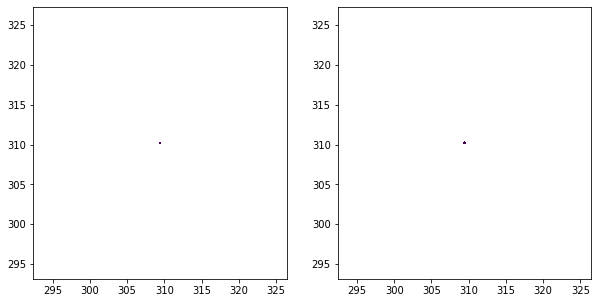

In [32]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.052

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.064

#### Trustworthiness

In [36]:
from sklearn.manifold import trustworthiness

In [37]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [38]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [39]:
tw, tw_test

(0.5051836929543635, 0.394954435483871)

### Save output metrics

In [40]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [41]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins,scvis,64,0.505184,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [42]:
save_loc = DATA_DIR / 'projection_metrics' /  algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [43]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins,scvis,64,0.394954,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [44]:
save_loc = DATA_DIR / 'projection_metrics' / algorithm / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [45]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = [algorithm, n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,scvis,64,cassins,0.064,0.052


In [46]:
save_loc = DATA_DIR / 'knn_classifier' / algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [48]:
#X_recon = vae.decoder.predict(vae.encoder.predict(X_test.reshape((len(X_test), 28, 28, 1)))[0])
X_recon,_ = model.decode(z_test)
X_real = X_test.reshape((len(X_test), 32, 32, 1))

In [49]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [50]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [51]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = [algorithm, 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,scvis,2,cassins,1.610792e+06,1269.169188,1269.183814,-2.778501e+19


In [52]:
save_loc = DATA_DIR / 'reconstruction_acc' / algorithm / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [54]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                np.array(y).flatten(), np.array(clustered_y).flatten()
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [55]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, algorithm, z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,cassins,scvis,"[[309.4398, 310.21002, 310.07355, 310.18015, 3...","[14, 11, 11, 11, 11, 11, 11, 11, 11, 17, 0, 0,...",64


In [56]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/scvis_64_cassins.pickle


n_clusters:   0%|          | 0/20 [00:00<?, ?it/s]

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (11). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (11). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (11). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (12). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (12). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (12). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (13). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (13). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (13). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (14). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (14). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (14). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (16). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (16). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (16). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (17). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (17). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (17). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (18). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (18). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (18). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (19). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (19). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (19). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (21). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (21). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (21). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (22). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (22). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (22). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (23). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (23). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (23). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (24). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (24). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (24). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (25). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (25). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (25). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (26). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (26). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (26). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (27). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (27). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (27). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (28). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (28). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (28). Possibly

init:   0%|          | 0/5 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (29). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (29). Possibly due to duplicate points in X.
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/silhouette.py:109: RuntimeWarning: invalid value encountered in true_divide
  sil_samples = (B - A) / np.maximum(A, B)
/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (29). Possibly

,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,cassins,scvis,64,0.0,0.0,1.0,0.0,0,10,"KMeans(n_clusters=10, random_state=0)"
1,cassins,scvis,64,0.0,0.0,1.0,0.0,1,10,"KMeans(n_clusters=10, random_state=1)"
2,cassins,scvis,64,0.0,0.0,1.0,0.0,2,10,"KMeans(n_clusters=10, random_state=2)"
3,cassins,scvis,64,0.0,0.0,1.0,0.0,3,10,"KMeans(n_clusters=10, random_state=3)"
4,cassins,scvis,64,0.0,0.0,1.0,0.0,4,10,"KMeans(n_clusters=10, random_state=4)"
...,...,...,...,...,...,...,...,...,...,...
95,cassins,scvis,64,0.0,0.0,1.0,0.0,0,29,"KMeans(n_clusters=29, random_state=0)"
96,cassins,scvis,64,0.0,0.0,1.0,0.0,1,29,"KMeans(n_clusters=29, random_state=1)"
97,cassins,scvis,64,0.0,0.0,1.0,0.0,2,29,"KMeans(n_clusters=29, random_state=2)"
98,cassins,scvis,64,0.0,0.0,1.0,0.0,3,29,"KMeans(n_clusters=29, random_state=3)"
